# Start with a simple Hidden Markov Model

In [29]:
import autograd.numpy as np
import autograd.numpy.random as npr
npr.seed(0)

import matplotlib.pyplot as plt
%matplotlib inline

from hips.plotting.colormaps import gradient_cmap, white_to_color_cmap
import seaborn as sns
sns.set_style("white")
sns.set_context("talk")

color_names = [
    "windows blue",
    "red",
    "amber",
    "faded green",
    "dusty purple",
    "orange"
    ]

colors = sns.xkcd_palette(color_names)
cmap = gradient_cmap(colors)

from ssm.models import HMM
from ssm.util import find_permutation

# Speficy whether or not to save figures
save_figures = True

In [2]:
# Set the parameters of the HMM
T = 200   # number of time bins
K = 5       # number of discrete states
D = 2       # data dimension

# Make an HMM
true_hmm = HMM(K, D, observations="gaussian")

# Manually tweak the means to make them farther apart
thetas = np.linspace(0, 2 * np.pi, K, endpoint=False)
true_hmm.observations.mus = 3 * np.column_stack((np.cos(thetas), np.sin(thetas)))

In [3]:
# Sample some data from the HMM
z, y = true_hmm.sample(T)
true_ll = true_hmm.log_probability(y)

In [4]:
# Plot the observation distributions
lim = .85 * abs(y).max()
XX, YY = np.meshgrid(np.linspace(-lim, lim, 100), np.linspace(-lim, lim, 100))
data = np.column_stack((XX.ravel(), YY.ravel()))
input = np.zeros((data.shape[0], 0))
mask = np.ones_like(data, dtype=bool)
tag = None
lls = true_hmm.observations.log_likelihoods(data, input, mask, tag)

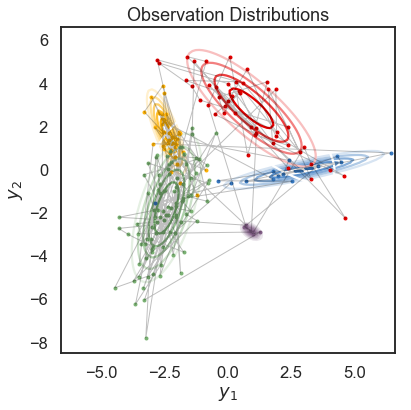

In [36]:
plt.figure(figsize=(6, 6))
for k in range(K):
    plt.contour(XX, YY, np.exp(lls[:,k]).reshape(XX.shape), cmap=white_to_color_cmap(colors[k]))
    plt.plot(y[z==k, 0], y[z==k, 1], 'o', mfc=colors[k], mec='none', ms=4)
    
plt.plot(y[:,0], y[:,1], '-k', lw=1, alpha=.25)
plt.xlabel("$y_1$")
plt.ylabel("$y_2$")
plt.title("Observation Distributions")

if save_figures:
    plt.savefig("hmm_1.pdf")

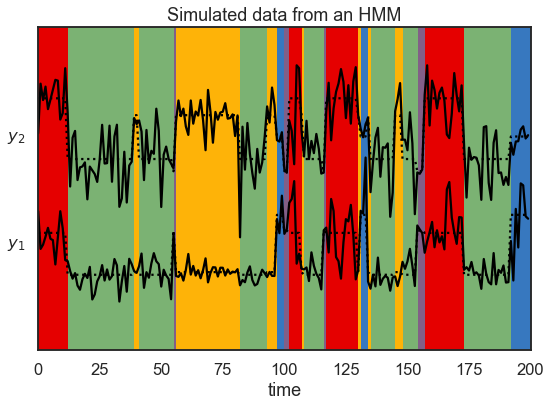

In [35]:
# Plot the data and the smoothed data
lim = 1.05 * abs(y).max()
plt.figure(figsize=(8, 6))
plt.imshow(z[None,:], aspect="auto", cmap=cmap, vmin=0, vmax=len(colors)-1, extent=(0, T, -lim, (D)*lim))

Ey = hmm.observations.mus[z]
for d in range(D):
    plt.plot(y[:,d] + lim * d, '-k')
    plt.plot(Ey[:,d] + lim * d, ':k')

plt.xlim(0, T)
plt.xlabel("time")
plt.yticks(lim * np.arange(D), ["$y_{}$".format(d+1) for d in range(D)])

plt.title("Simulated data from an HMM")

plt.tight_layout()

if save_figures:
    plt.savefig("hmm_2.pdf")

# Fit an HMM to this synthetic data

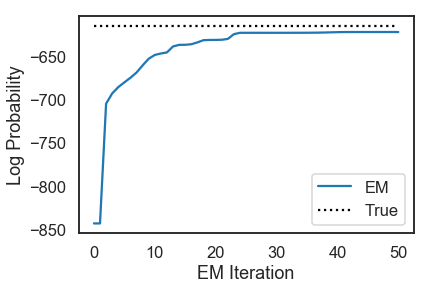

In [7]:
N_iters = 50
hmm = HMM(K, D, observations="gaussian")
hmm_lls = hmm.fit(y, method="em", num_em_iters=N_iters, verbose=True)

plt.plot(hmm_lls, label="EM")
plt.plot([0, N_iters], true_ll * np.ones(2), ':k', label="True")
plt.xlabel("EM Iteration")
plt.ylabel("Log Probability")
plt.legend(loc="lower right")

In [8]:
# Find a permutation of the states that best matches the true and inferred states
hmm.permute(find_permutation(z, hmm.most_likely_states(y)))

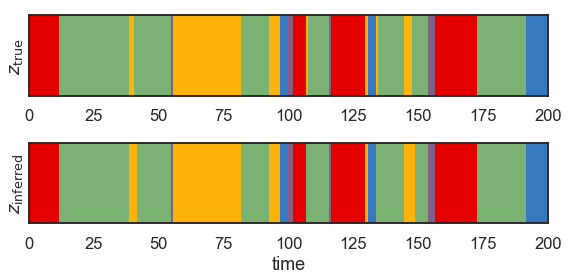

In [11]:
# Plot the true and inferred discrete states
hmm_z = hmm.most_likely_states(y)

plt.figure(figsize=(8, 4))
plt.subplot(211)
plt.imshow(z[None,:], aspect="auto", cmap=cmap, vmin=0, vmax=len(colors)-1)
plt.xlim(0, T)
plt.ylabel("$z_{\\mathrm{true}}$")
plt.yticks([])

plt.subplot(212)
plt.imshow(hmm_z[None,:], aspect="auto", cmap=cmap, vmin=0, vmax=len(colors)-1)
plt.xlim(0, T)
plt.ylabel("$z_{\\mathrm{inferred}}$")
plt.yticks([])
plt.xlabel("time")

plt.tight_layout()

Text(0.5,0,'time')

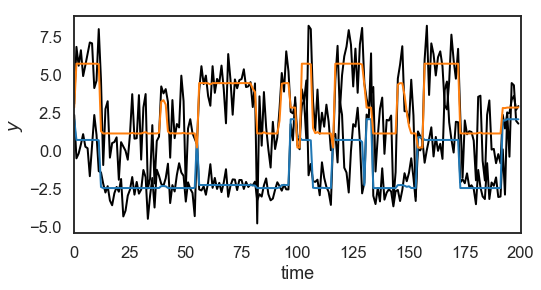

In [34]:
# Use the HMM to "smooth" the data
hmm_y = hmm.smooth(y)

plt.figure(figsize=(8, 4))
plt.plot(y + 3 * np.arange(D), '-k', lw=2)
plt.plot(hmm_y + 3 * np.arange(D), '-', lw=2)
plt.xlim(0, T)
plt.ylabel("$y$")
# plt.yticks([])
plt.xlabel("time")